In [1]:
#!conda install -y -c anaconda pillow
#!conda install -y -c conda-forge ipywidgets

Referencias: 
- http://www.geocities.ws/fg_audio/Archivos/Trabajo_Ventanas.pdf
- http://ri.uaemex.mx/bitstream/handle/20.500.11799/35463/secme-23096.pdf?sequence=1
- Formatos de imagenes soportados por PIL: https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html

# Ejercicio 2.1

In [224]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

In [225]:
import warnings
warnings.simplefilter('ignore')

In [226]:
%matplotlib inline
plt.style.use('classic')


In [227]:
def load_image(img, channels = 3):
    imgmat_array = np.array(list(img.getdata()), float)
    print (f"Image shape: {imgmat_array.shape}")
    imgmat_array = imgmat_array / 255
    imgmat = imgmat_array
    imgmat.shape = (img.size[1], img.size[0] , channels )
    return (imgmat , imgmat_array)


def load_image_from_disk (image_path, channels = 3):
    img = Image.open(image_path)
    return load_image(img, channels)

def load_image_from_url(image_url , channels = 3):
    response = requests.get(image_url , timeout=30)
    img = Image.open(BytesIO(response.content))
    return load_image(img, channels)


def display_image (imgmat):
    plt.figure(figsize=(9, 6))
    #plt.imshow((imgmat * 255).astype(np.uint8))
    plt.imshow(imgmat)
    plt.show()

In [230]:
img_url = "https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/parrots.jpeg"
imgmat , imgmat_array = load_image_from_url(img_url)


# Desde disco local
# imgmat , imgmat_array = load_image_from_disk('images/parrot.jpg')


Image shape: (98304, 3)


## Imagen original

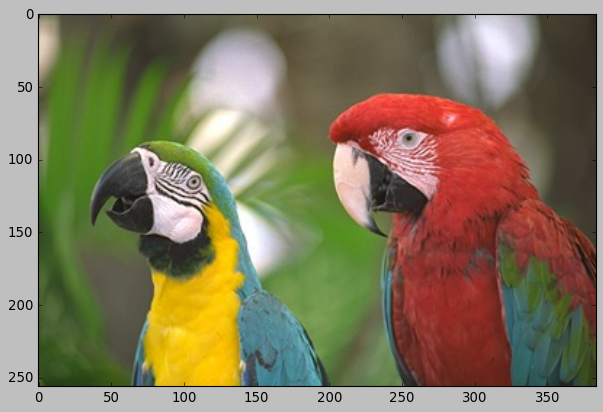

In [232]:
display_image (imgmat)

In [233]:
def generate_yiq_from_rgb(imgmat_array):
    
    yiq_from_rgb_extended = np.array([[0.299,      0.587,        0.114],
                        [0.59590059, -0.27455667, -0.32134392],
                        [0.21153661, -0.52273617, 0.31119955]])
    
    yiq_from_rgb = np.array([[0.299,      0.587,        0.114],
                        [0.595716, -0.274453, -0.321263],
                        [0.211456, -0.522591, 0.311135]])
    
    
    
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def generate_rgb_from_yiq(imgmat_array , alpha , beta):
    yiq_from_rgb = np.array([[1 * alpha, 0.9663 * beta, 0.6210 * beta],
                             [1 * alpha , -0.2721 * beta, -0.6474 * beta],
                             [1 * alpha, -1.1070 * beta, 1.7046* beta] ])
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def iq_strategy_coerce(i,q, beta, i_original, q_original ):

    i_max = 0.5957
    i_min = i_max * -1
    
    q_max = 0.5226
    q_min = q_max * -1

    q_diff = 0
    
    i_coerced = i
    q_coerced = q
    
    if abs(i) > i_max:
        i_coerced = i_min  if i < 0 else i_max
        
    
    if abs(q) > q_max:
        q_coerced = q_min  if i < 0 else q_max

        
    return (i_coerced , q_coerced)



def modidify_yiq (imgmat_array , alpha , beta , iq_strategy):
  
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            y = alpha * yc[0]
            i = beta * yc[1]
            q = beta * yc[2]
           
            if y > 1:
                y = 1
            
            
            (i,q) = iq_strategy(i,q, beta, yc[1], yc[2])
            
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    return generated_array;
    
    
def generate_rgb_from_yiq_control(imgmat_array ):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
   
    result =  np.dot(imgmat_array, rgb_from_yiq.T.copy())
    
    return result 






In [234]:
class UnAcceptedValueError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

class Base_Kernel:
    
    def __init__(self, matrix):
       
        self.matrix = matrix
        
        self.check_kernel()
       
        
    def check_kernel(self):
        if (self.matrix.shape[0] != self.matrix.shape[1]):
            raise UnAcceptedValueError("El kernel debe ser cuadrado")
            
        if (self.matrix.shape[0] % 2 == 0):
            raise UnAcceptedValueError("La cantidad de filas y columnas debe ser impar")
 
    def get_shape(self):
        return (self.matrix.shape)
    
    def get_anchor(self):
        return None;
 
    
class Square_Kernel(Base_Kernel):
   
    def __init__(self, matrix):
        super().__init__(matrix)
        
        
    
    def get_anchor(self):
    
        x = int(self.matrix.shape[0]/2)
        y = x
        return (x,y)
    
   
    
    def process(self, matrix_b):
        
        result = 0 
        if ((matrix_b.shape[0] != self.matrix.shape[0] ) or (matrix_b.shape[1] != self.matrix.shape[1])):
            raise UnAcceptedValueError(f"Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a{self.matrix.shape} Matris b{matrix_b.shape}")

        
        for xc_index, xc in enumerate(self.matrix):
            for yc_index, yc in enumerate(xc):
                
                result = result + (yc * matrix_b[xc_index][yc_index])
            
        return result



    
# De este kernel deberian heredar todos los kernels morfoloficos. Se supone que todos van a devolver 0,0 como anchor,
# Pero el metodo process de cada uno es diferente

class Morphologic_Kernel_(Base_Kernel):
    def __init__(self, threshold,matrix):
        super().__init__(matrix)
        self.threshold = threshold
        
    def get_anchor(self):
    
        x = int(self.matrix.shape[0]/2)
        y = x
        return (x,y)
    
      
    
class Erosion_Kernel_(Morphologic_Kernel_):
    
    def __init__(self,threshold, matrix):
        super().__init__(threshold,matrix)
        
        
   
    def process(self, matrix_b):

        if ((matrix_b.shape[0] != self.matrix.shape[0] ) or (matrix_b.shape[1] != self.matrix.shape[1])):
            raise UnAcceptedValueError(f"Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a{self.matrix.shape} Matris b{matrix_b.shape}")

        #print (f"Shape del kernel {self.matrix.shape}")
        for xc_index, xc in enumerate(self.matrix):
            for yc_index, yc in enumerate(xc):
                if (yc == 1):
                    #print (f"Valor de yc{1}")
                    #print (f"Valor de matriz {matrix_b[xc_index][yc_index]}")
                    if (matrix_b[xc_index][yc_index] < self.threshold):
                        
                        return 0

        return 1

class Kernel_Lumenance(Base_Kernel):
    
   
    EROSION = 1
    DILATION = 2
    
    def __init__(self, type_operation, matrix):
        super().__init__(matrix)
        
        self.type_operation = type_operation
 

    def get_anchor(self):
    
        x = int(self.matrix.shape[0]/2)
        y = x
        return (x,y)
    
   
    def process(self, matrix_b):

        if ((matrix_b.shape[0] != self.matrix.shape[0] ) or (matrix_b.shape[1] != self.matrix.shape[1])):
            raise UnAcceptedValueError(f"Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a{self.matrix.shape} Matris b{matrix_b.shape}")

    
        if (self.type_operation == self.EROSION):
            return matrix_b.min()
        else:
            return  matrix_b.max()
        
class Median_Kernel(Base_Kernel):
    

    
    def __init__(self, matrix):
        super().__init__(matrix)
        
        

    def get_anchor(self):
    
        x = int(self.matrix.shape[0]/2)
        y = x
        return (x,y)
    
   
    def process(self, matrix_b):

        if ((matrix_b.shape[0] != self.matrix.shape[0] ) or (matrix_b.shape[1] != self.matrix.shape[1])):
            raise UnAcceptedValueError(f"Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a{self.matrix.shape} Matris b{matrix_b.shape}")

    
        return  np.median(matrix_b)
        



class Image_Matrix:
    
    #La imagen debe ser YIQ (imgmat_array)
    def __init__(self, imgmat_array , kernel ):

        self.imgmat_array = imgmat_array
        self.kernel = kernel
        self.expanded_matrix = None
        
        
   
    #Método privado. Toma el kernel y en base a ello le agrega filas y columnas
    #a la imagen. Le agrega tantas filas y columnas de manera tal que el kernel pueda
    # ir elemento x elemento de la imagen original y siempre tenga valores para tomar de la 
    # imagen
    def _expand_matrix (self): 
    
        factor = 2
        kernel_centroid = self.kernel.get_anchor()
        centroide = kernel_centroid[0]
        
        
        print (f"Kernel anchor {centroide}")
        A = self.imgmat_array[:,:,0]
        print (f" Shape A {A.shape}")
        
        A_1 =np.zeros((A.shape[0] + factor * centroide  ,A.shape[1] ))
        print (f" Shape A_1 {A_1.shape}")
    
        A_1[centroide:-centroide, :] =A 
        A_1[0:centroide,:] = A[0]
        A_1[-centroide:,:] = A[A.shape[0]-1]

       
        
        A_2 =np.zeros((A_1.shape[0] ,A_1.shape[1] + factor * centroide ))
        print (f" Shape A_2 {A_2.shape}")
            
       
        
        A_2[:, centroide:-centroide] =A_1 
        A_2[:,0:centroide] = A_1[:,0:1]
        A_2[:,-centroide:] = A_1[:,A_1.shape[1]-1:]
        
        #Se puede calcular una vez y luego reutilizar n veces en el apply_filter
        self.expanded_matrix = A_2
        
        return A_2


    #Saca de la imagen, la matriz a la cual se le tiene que hacer la operación punto con el kernel
    def _get_sub_matrix(self, row, col, expanded_image):
        
        kernel_shape = self.kernel.get_shape()
        kernel_anchor = self.kernel.get_anchor()
        
        
        #print(f"Se crea la sub matrix con shape {kernel_shape}")
        sub_matrix =np.zeros(kernel_shape)
        #print(f"Kernel centroide {kernel_centroid}")
        start_row = row - kernel_anchor[0]
        end_row = row +  kernel_anchor[0] + 1
        
        start_col = col - kernel_anchor[1]
        end_col = col + kernel_anchor[1] + 1
        
        #print(f" Se extra de expanded_image las filas: {start_row} - {end_row}")
        #print(f" Se extrae de expanded_image las columnas: {start_col} - {end_col}")
        sub_matrix = expanded_image[start_row: end_row ,start_col: end_col ]
        #print (sub_matrix)
        
        return sub_matrix
    
        
    def apply_filter_yiq (self):

        #Se puede optimizar usando self.expanded_matrix en vez de calcular a cada rato la 
        #matriz expandida
        expanded_image = self._expand_matrix()
        
        filtered_image = np.empty(shape = self.imgmat_array.shape )

        kernel_anchor = self.kernel.get_anchor()

        row_start_index = kernel_anchor[0]
        row_end_index = expanded_image.shape[0] - kernel_anchor[0] - 1
        col_start_index = kernel_anchor[1]
        col_end_index = expanded_image.shape[1] - kernel_anchor[1] - 1
        
        
        print (f"Rango row: {row_start_index} - {row_end_index} , col: {col_start_index} - {col_end_index}")
        
       
        for row in range(row_start_index, row_end_index):
            #print (f"fila {row}")
            for col in range(col_start_index,col_end_index ):
                #print (f"columna {col}")
                #print (self.imgmat_array[row,col,0])
                sub_matrix = self._get_sub_matrix(row, col , expanded_image)
                #print (f" Submatrix: {sub_matrix}")
                filtered_image[row - 1 , col - 1] = self.kernel.process(sub_matrix)
                #print(f"Valor del pixel {filtered_image[row - 1 , col - 1]}")
        
        #Creo una matrix N x M x 3 (YIQ, todos los valores en 0)
        #filtered_image_yiq = np.zeros(shape = (filtered_image.shape[0] , filtered_image.shape[1], 3) )

        #print(f"filtered_image_yiq: {filtered_image_yiq.shape} filtered_image {filtered_image.shape} ")
        #Cambio el canal Y, I & Q quedan en 0
        #filtered_image_yiq[:,:,0] = filtered_image[:]


        
        #return filtered_image_yiq;
        return filtered_image

In [235]:
result = generate_yiq_from_rgb(imgmat_array)

In [236]:
A5 = np.full((5, 5), 1/25)
kernel = Square_Kernel(A5)

In [237]:
image_matrix = Image_Matrix(imgmat_array, kernel)
expanded_matrix = image_matrix._expand_matrix()
filtered_image  = image_matrix.apply_filter_yiq()


Kernel anchor 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)
Kernel anchor 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)
Rango row: 2 - 257 , col: 2 - 385


In [239]:
expanded_matrix.shape
expanded_matrix_2 = np.zeros(shape = (expanded_matrix.shape[0] , expanded_matrix.shape[1], 3) )
expanded_matrix_2.shape


(260, 388, 3)

## Imagen en escala de grises

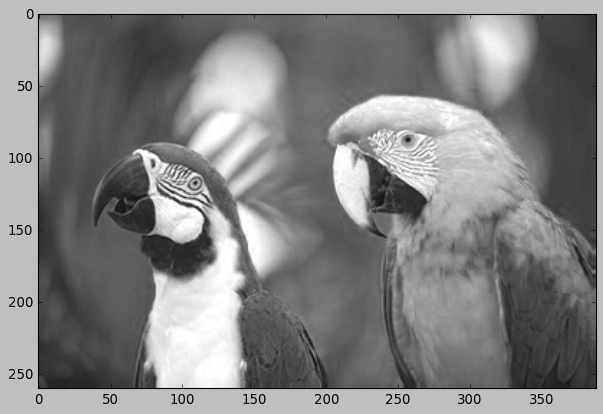

In [240]:

expanded_matrix_2[:,:,0] = expanded_matrix
expanded_matrix_rgb = generate_rgb_from_yiq_control(expanded_matrix_2)
display_image (expanded_matrix_rgb)


# Filtrado Plano

## Ejemplo con Kernel 3 x 3

Kernel anchor 1
 Shape A (256, 384)
 Shape A_1 (258, 384)
 Shape A_2 (258, 386)
Rango row: 1 - 256 , col: 1 - 384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


filtered:image:(256, 384, 3)


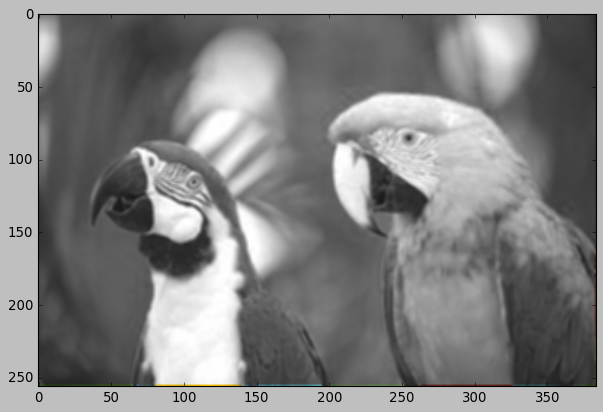

In [241]:
A3 = np.full((3, 3), 1/9)
kernel = Square_Kernel(A3)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

print(f"filtered:image:{filtered_image.shape}")
display_image (filtered_image)

## Ejemplo con Kernel 5 x 5

Kernel anchor 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)
Rango row: 2 - 257 , col: 2 - 385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


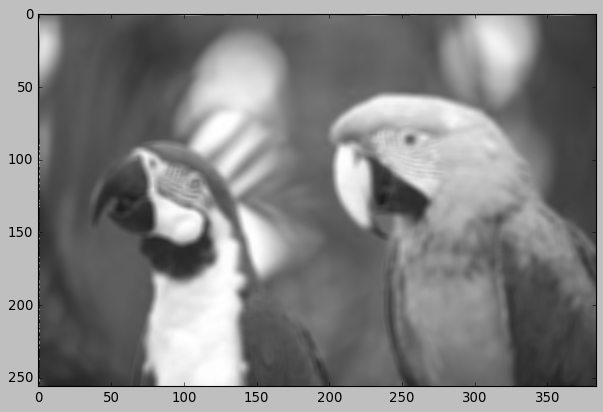

In [242]:
A5 = np.full((5, 5), 1/25)
kernel = Square_Kernel(A5)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Bartlett

## Barlet 3x3

sum [0.25 0.5  0.25]
Kernel anchor 1
 Shape A (256, 384)
 Shape A_1 (258, 384)
 Shape A_2 (258, 386)
Rango row: 1 - 256 , col: 1 - 384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


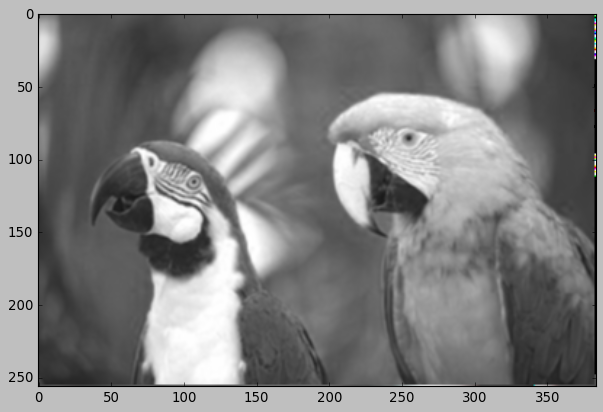

In [243]:

B3 = np.array([[1, 2, 1], [2, 4,2] , [1,2,1]])
B3 = B3 / B3.sum()

print (f"sum {sum(B3)}")
kernel = Square_Kernel(B3)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

## Barlet 5x5

Kernel anchor 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)
Rango row: 2 - 257 , col: 2 - 385


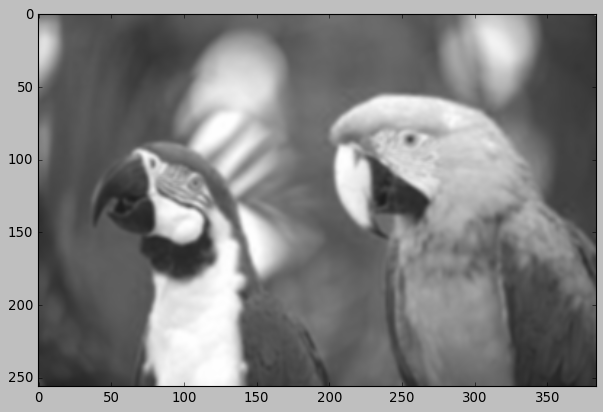

In [244]:
B5 = np.array([[1, 2, 3,2,1],[2,4,6,4,2] , [3,6,9,6,3] ,[2,4,6,4,2] , [1,2,3,2,1] ])

B5 = B5 / B5.sum()
kernel = Square_Kernel(B5)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Gaussiano

In [245]:
# http://solucioningenieril.com/vision_artificial/filtros_en_imagenes

#img_url = "http://solucioningenieril.com/imagenes/asignaturas/vision_artificial/tema_9/1.png"
#imgmat , imgmat_array = load_image_from_url(img_url)


# Usando esta imagen se nota como funciona el filtro gaussiano
# https://programmerclick.com/article/85601720182/
    
img_url = "https://images1.programmerclick.com/85/33/3397bab3f7b2d8bc1c4d4cf489f70f2d.png"
imgmat , imgmat_array = load_image_from_url(img_url)
    

# https://programmerclick.com/article/8202958942/
# https://programmerclick.com/images/447/bf85da593f12c57f1c9d0b44e1b554f7.png

#img_url = "http://programmerclick.com/images/447/bf85da593f12c57f1c9d0b44e1b554f7.png"
#imgmat , imgmat_array = load_image_from_url(img_url)



# Desde disco local
# imgmat , imgmat_array = load_image_from_disk('images/parrot.jpg')



Image shape: (286670, 3)


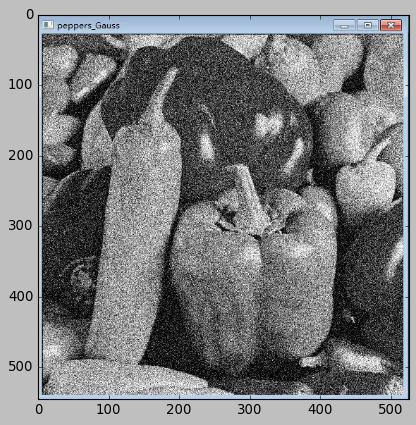

In [246]:
display_image (imgmat)

## Gaussiano 5 x 5 

sum [0.0625 0.25   0.375  0.25   0.0625]
Kernel anchor 2
 Shape A (545, 526)
 Shape A_1 (549, 526)
 Shape A_2 (549, 530)
Rango row: 2 - 546 , col: 2 - 527


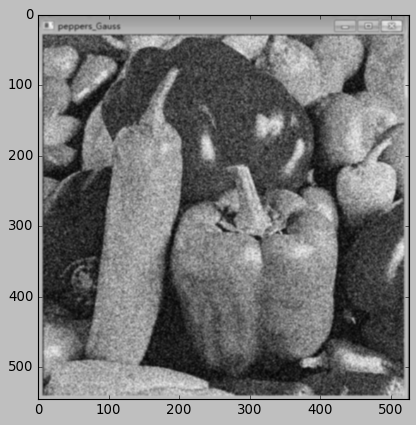

In [247]:
G5 = np.array([[1, 4, 6,4,1],[4,16,24,16,4] , [6,24,36,24,6], [4,16,24,16,4] , [1,4,6,4,1] ])
G5 = G5 / G5.sum()

print (f"sum {sum(G5)}")
kernel = Square_Kernel(G5)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

Kernel anchor 1
 Shape A (545, 526)
 Shape A_1 (547, 526)
 Shape A_2 (547, 528)
Rango row: 1 - 545 , col: 1 - 526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


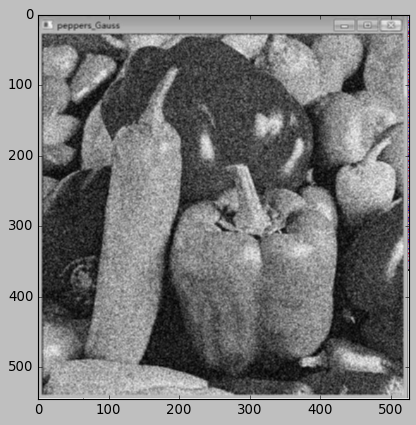

In [248]:
A3 = np.full((3, 3), 1/9)
kernel = Square_Kernel(A3)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Laplaciano

## Laplaciano V4

In [249]:
img_url = "https://mott.pe/noticias/wp-content/uploads/2018/03/5-razones-por-las-que-debes-hacer-fotograf%C3%ADas-en-blanco-y-negro-creatividad.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)


Image shape: (388080, 3)


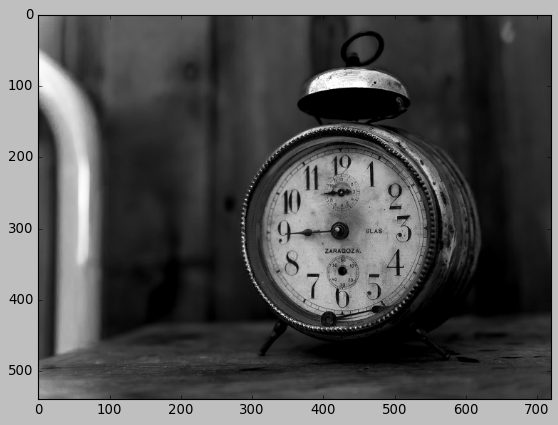

In [250]:
display_image (imgmat)

sum [-1  2 -1]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


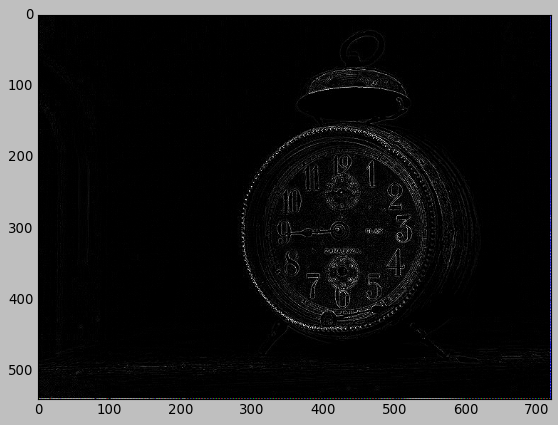

In [251]:
L4 = np.array([[0,-1,0] , [-1,4,-1] , [0,-1,0] ])


print (f"sum {sum(L4)}")
kernel = Square_Kernel(L4)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

sum [-3  6 -3]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


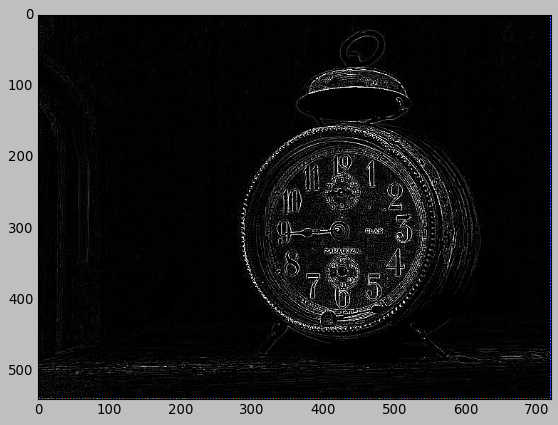

In [252]:
L4 = np.array([[-1,-1,-1] , [-1,8,-1] , [-1,-1,-1] ])


print (f"sum {sum(L4)}")
kernel = Square_Kernel(L4)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Sobel 4 orientaciones

In [253]:
img_url = "https://mott.pe/noticias/wp-content/uploads/2018/03/5-razones-por-las-que-debes-hacer-fotograf%C3%ADas-en-blanco-y-negro-creatividad.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)


Image shape: (388080, 3)


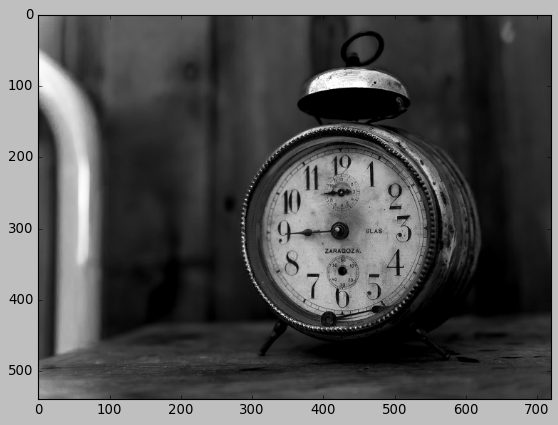

In [254]:
display_image (imgmat)

sum [-4  0  4]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


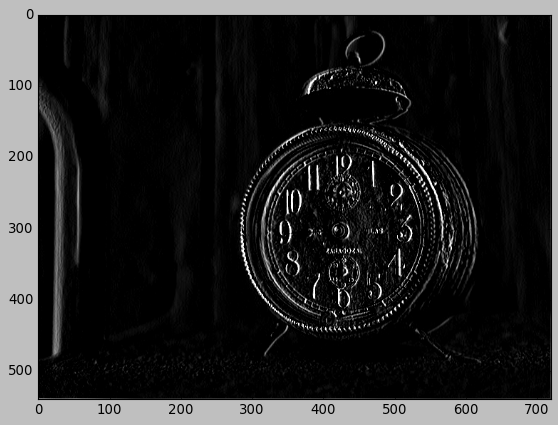

In [255]:
S1 = np.array([[-1,0,1] , [-2,0,2] , [-1,0,1] ])


print (f"sum {sum(S1)}")
kernel = Square_Kernel(S1)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

### Roto el kernel 90

sum [0 0 0]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


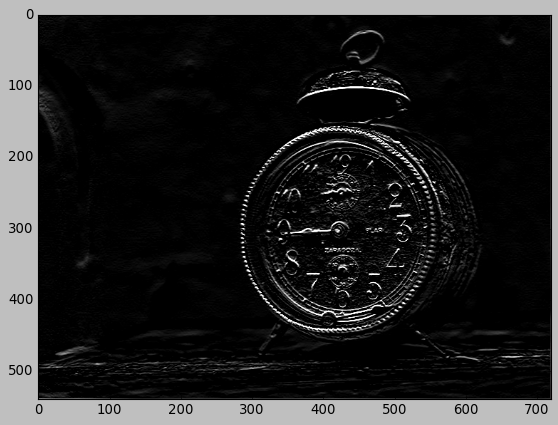

In [256]:
S1 = np.rot90(S1)
print (f"sum {sum(S1)}")
kernel = Square_Kernel(S1)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

### Roto el kernel 90 (180 en total)

sum [ 4  0 -4]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


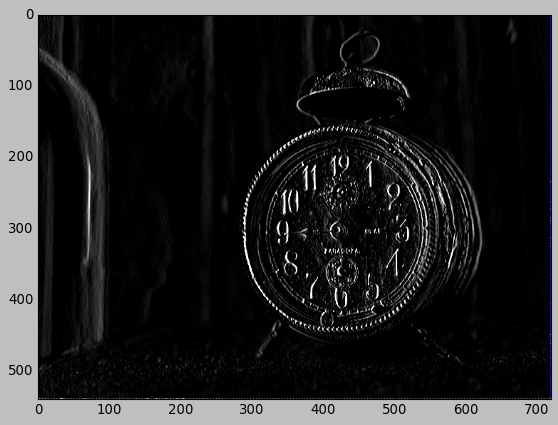

In [257]:
S1 = np.rot90(S1)
print (f"sum {sum(S1)}")
kernel = Square_Kernel(S1)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

### Roto el kernel 90 (270 en total)

sum [0 0 0]
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


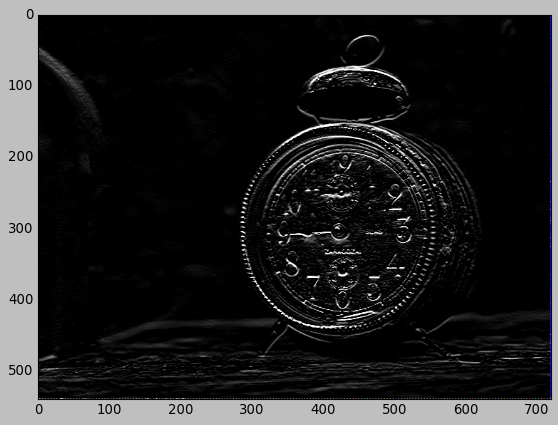

In [258]:
S1 = np.rot90(S1)
print (f"sum {sum(S1)}")
kernel = Square_Kernel(S1)

image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Diferencia de gaussianas

In [259]:
img_url = "https://mott.pe/noticias/wp-content/uploads/2018/03/5-razones-por-las-que-debes-hacer-fotograf%C3%ADas-en-blanco-y-negro-creatividad.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (388080, 3)


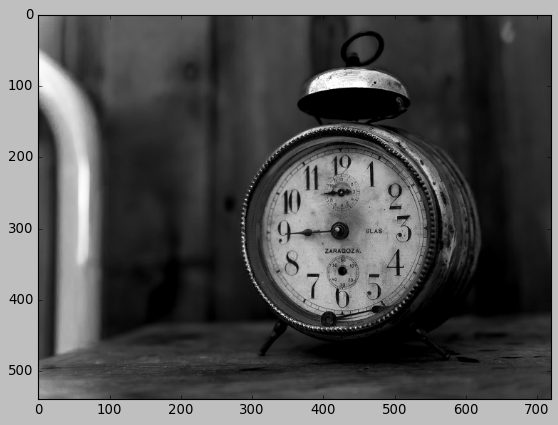

In [260]:
display_image (imgmat)

In [261]:
G5 = np.array([[1, 4, 6,4,1],[4,16,24,16,4] , [6,24,36,24,6], [4,16,24,16,4] , [1,4,6,4,1] ])
G5 = G5 / G5.sum()

 

G3 = np.array([[1, 2, 1], [2, 4,2] , [1,2,1]])
G3 = G3 / G3.sum()

print (f"G5 sum {sum(G5)}")
kernel_G5 = Square_Kernel(G5)

print (f"G·sum {sum(G3)}")
kernel_G3 = Square_Kernel(G3)

image_matrix = Image_Matrix(imgmat_array, kernel_G5)
filtered_image_G5  = image_matrix.apply_filter_yiq()


image_matrix = Image_Matrix(imgmat_array, kernel_G3)
filtered_image_G3  = image_matrix.apply_filter_yiq()




G5 sum [0.0625 0.25   0.375  0.25   0.0625]
G·sum [0.25 0.5  0.25]
Kernel anchor 2
 Shape A (539, 720)
 Shape A_1 (543, 720)
 Shape A_2 (543, 724)
Rango row: 2 - 540 , col: 2 - 721
Kernel anchor 1
 Shape A (539, 720)
 Shape A_1 (541, 720)
 Shape A_2 (541, 722)
Rango row: 1 - 539 , col: 1 - 720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


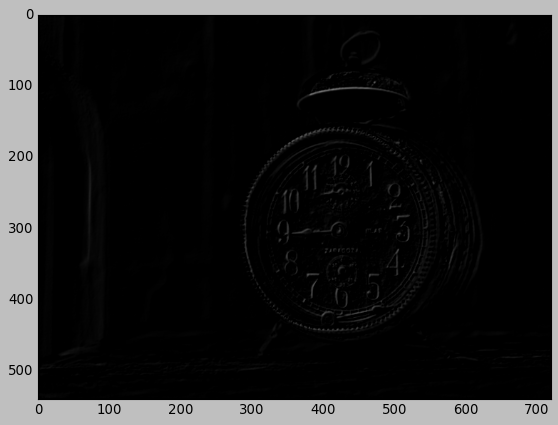

In [262]:
filtered_image =  filtered_image_G5 - filtered_image_G3 
display_image (filtered_image)

# Ejerccio 2.2

Referencia: 

- http://dsp1.materia.unsl.edu.ar/Procesamiento%20Morfologico.pdf

- https://towardsdatascience.com/image-processing-part-3-dbf103622909

- https://python.plainenglish.io/complete-understanding-of-morphological-transformations-in-image-processing-eadb337e9d5c

## Erosión

In [263]:
#img_url = "https://miro.medium.com/max/390/1*ocF_RcgnVHRRIZJSnuF8CQ.jpeg"
#img_url = "https://images.unsplash.com/photo-1520262494112-9fe481d36ec3?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8YmxhY2slMjBhbmQlMjB3aGl0ZSUyMG5hdHVyZXxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
#img_url = "https://image.shutterstock.com/image-vector/geometric-shapes-rectangle-icon-simple-260nw-1615657138.jpg"
#img_url = "https://cdn5.vectorstock.com/i/1000x1000/84/14/white-alphabet-letters-on-black-background-vector-38168414.jpg"   
img_url = "https://m.media-amazon.com/images/I/814rdnWjO3L.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (1809832, 3)


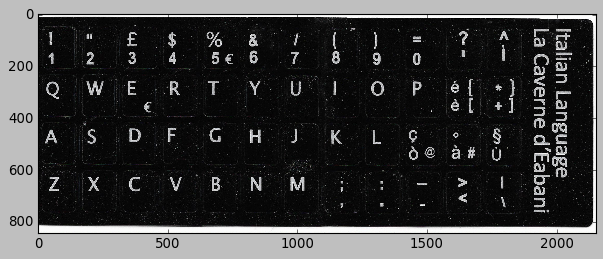

In [264]:
display_image (imgmat)

In [265]:
imgmat.shape

(841, 2152, 3)

Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152


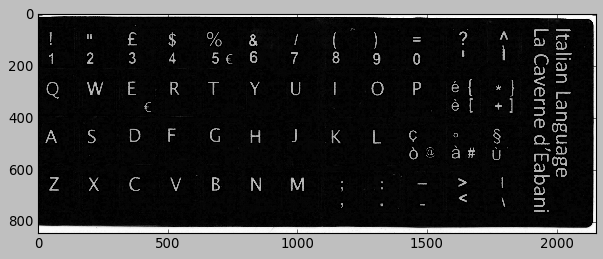

In [266]:
E1 = np.full((3, 3), 1)
#kernel = Erosion_Kernel_( 0.2,E1)


kernel = Kernel_Lumenance(Kernel_Lumenance.EROSION, E1)
    
image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

# Dilatación

Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152


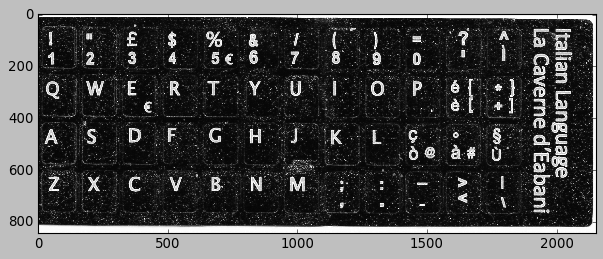

In [267]:
D1 = np.full((3, 3), 1)
#kernel = Erosion_Kernel_( 0.2,E1)


kernel = Kernel_Lumenance(Kernel_Lumenance.DILATION, D1)
    
image_matrix = Image_Matrix(imgmat_array, kernel)
filtered_image  = image_matrix.apply_filter_yiq()

display_image (filtered_image)

## Apertura

In [268]:
img_url = "https://m.media-amazon.com/images/I/814rdnWjO3L.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (1809832, 3)


In [269]:
def apertura(imgmat_array):
    
    # Erosión
    E1 = np.full((3, 3), 1)


    kernel = Kernel_Lumenance(Kernel_Lumenance.EROSION, E1)

    image_matrix = Image_Matrix(imgmat_array, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()

    # Dilatacion
    
    
    D1 = np.full((3, 3), 1)


    kernel = Kernel_Lumenance(Kernel_Lumenance.DILATION, D1)

    image_matrix = Image_Matrix(filtered_image, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()
    
    return filtered_image

In [270]:
filtered_image = apertura(imgmat_array)

Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152
Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


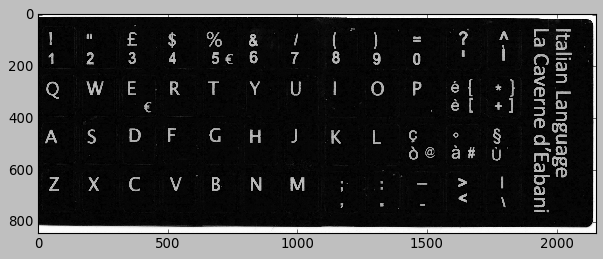

In [271]:
display_image (filtered_image)

## Cierre

In [272]:
img_url = "https://m.media-amazon.com/images/I/814rdnWjO3L.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (1809832, 3)


In [273]:
def cierre(imgmat_array):
    
    
    # Dilatacion
    
    D1 = np.full((3, 3), 1)

    kernel = Kernel_Lumenance(Kernel_Lumenance.DILATION, D1)

    image_matrix = Image_Matrix(imgmat_array, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()
    
    # Erosión
    E1 = np.full((3, 3), 1)


    kernel = Kernel_Lumenance(Kernel_Lumenance.EROSION, E1)

    image_matrix = Image_Matrix(filtered_image, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()

    
    
    
    return filtered_image

In [274]:
filtered_image = cierre(imgmat_array)

Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152
Kernel anchor 1
 Shape A (841, 2152)
 Shape A_1 (843, 2152)
 Shape A_2 (843, 2154)
Rango row: 1 - 841 , col: 1 - 2152


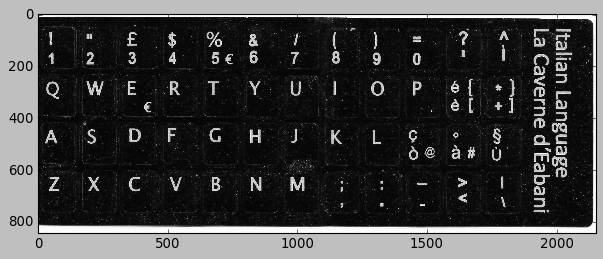

In [275]:
display_image (filtered_image)

## Frontera exterior

In [276]:
img_url = "https://thumbs.dreamstime.com/z/white-circles-black-background-white-circle-isolated-black-different-circles-black-background-white-circles-black-171156002.jpg"
imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (1848000, 3)


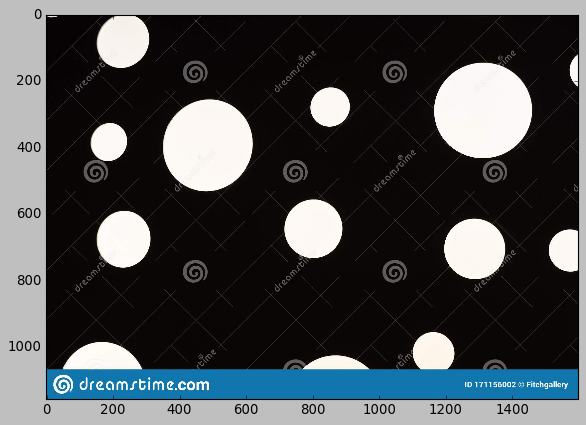

In [277]:
display_image (imgmat_array)

In [278]:
def frontera(imgmat_array):
    
    
    # Dilatacion
    
    D1 = np.full((3, 3), 1)

    kernel = Kernel_Lumenance(Kernel_Lumenance.DILATION, D1)

    image_matrix = Image_Matrix(imgmat_array, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()
    
 
    
    filtered_image = filtered_image - imgmat_array 
    
    return filtered_image

In [279]:
filtered_image = frontera(imgmat_array)

Kernel anchor 1
 Shape A (1155, 1600)
 Shape A_1 (1157, 1600)
 Shape A_2 (1157, 1602)
Rango row: 1 - 1155 , col: 1 - 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


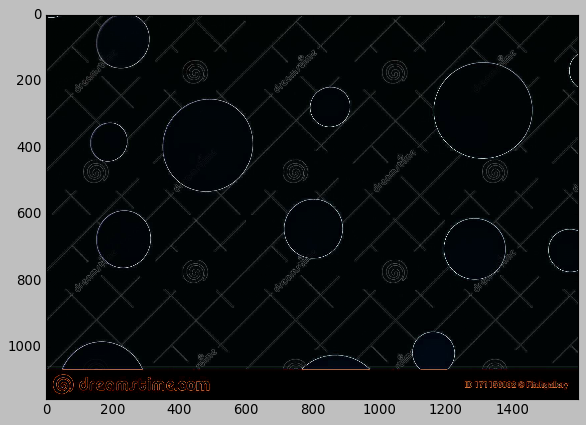

In [280]:
display_image (filtered_image)

## Mediana

In [281]:
# img_url = "https://thumbs.dreamstime.com/z/white-circles-black-background-white-circle-isolated-black-different-circles-black-background-white-circles-black-171156002.jpg"
 
img_url = "https://images1.programmerclick.com/85/33/3397bab3f7b2d8bc1c4d4cf489f70f2d.png"

imgmat , imgmat_array = load_image_from_url(img_url)

Image shape: (286670, 3)


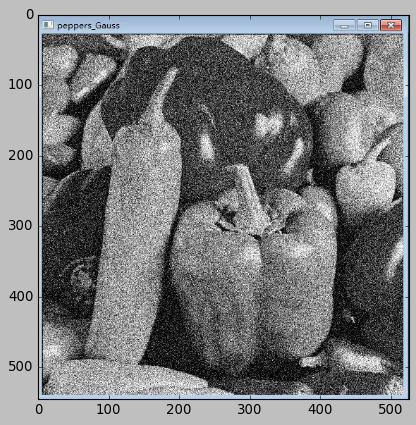

In [282]:
display_image (imgmat_array)

In [283]:
def mediana(imgmat_array):
    
    
    # Dilatacion
    
    M1 = np.full((3, 3), 1)

    kernel = Median_Kernel( M1)

    image_matrix = Image_Matrix(imgmat_array, kernel)
    filtered_image  = image_matrix.apply_filter_yiq()
    
 
    
    #filtered_image = filtered_image - imgmat_array 
    
    return filtered_image

In [284]:
filtered_image = mediana(imgmat_array)

Kernel anchor 1
 Shape A (545, 526)
 Shape A_1 (547, 526)
 Shape A_2 (547, 528)
Rango row: 1 - 545 , col: 1 - 526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


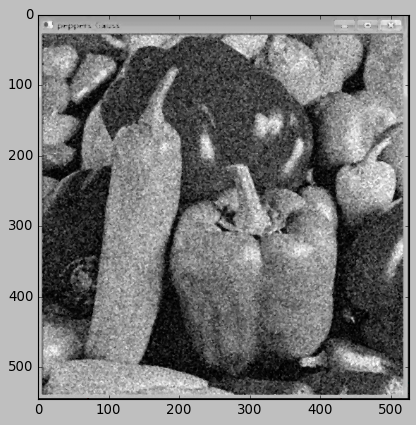

In [285]:
display_image (filtered_image)

## Top Hat

In [286]:
img_url = "https://media.istockphoto.com/vectors/eye-veins-and-vessels-vector-id915391890?s=612x612"

imgmat , imgmat_array = load_image_from_url(img_url)


Image shape: (374544, 3)


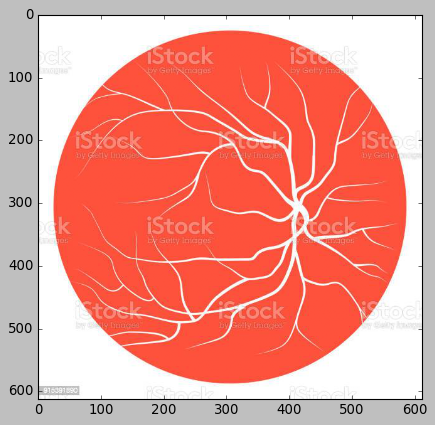

In [287]:
display_image (imgmat_array)

In [288]:
result = generate_yiq_from_rgb(imgmat_array)

In [289]:
black_white_image = np.zeros(shape = (result.shape[0] , result.shape[1], 3) )


print (f"{black_white_image.shape}")
black_white_image[:,:,0] = result[:,:,0]
imgmat_array = generate_rgb_from_yiq_control(black_white_image)


(612, 612, 3)


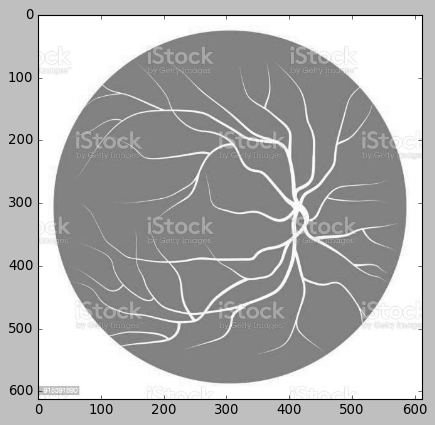

In [290]:
display_image (imgmat_array)

In [291]:
def top_hat(imgmat_array):
    
    
    
    
    filtered_image = apertura (imgmat_array)
    
    filtered_image = imgmat_array - filtered_image
    
    
    return filtered_image

In [292]:
filtered_image = top_hat(imgmat_array)

Kernel anchor 1
 Shape A (612, 612)
 Shape A_1 (614, 612)
 Shape A_2 (614, 614)
Rango row: 1 - 612 , col: 1 - 612
Kernel anchor 1
 Shape A (612, 612)
 Shape A_1 (614, 612)
 Shape A_2 (614, 614)
Rango row: 1 - 612 , col: 1 - 612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


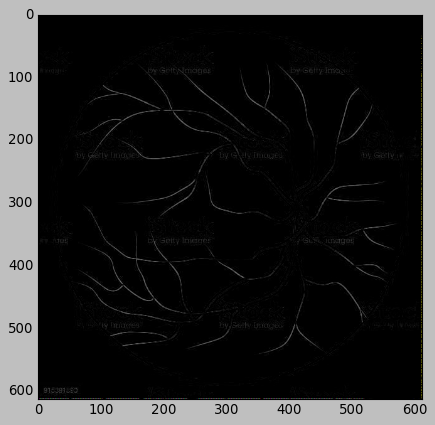

In [293]:
display_image (filtered_image)